# LeNet5

# LIBRARIES

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Device configuration

# CONSTANTS

In [3]:
BATCH_SIZE = 32
WIDTH = 28
HEIGHT = 28
CHANNELS = 1
EPOCHS = 30

In [4]:
my_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# DOWNLOAD AND LOAD DATASET

In [5]:
mnist_train_val = MNIST('/mnt/files/Datasets/', train=True, download=True, transform=my_transforms)

## train & Val

In [6]:
mnist_train, mnist_val = random_split(mnist_train_val, [55000, 5000])

## test

In [7]:
mnist_test = MNIST('/mnt/files/Datasets/', train=False, download=True, transform=my_transforms)

# EXPLORING DATA

In [8]:
dataset_train_size = len(mnist_train)
print(f"size of train dataset = {dataset_train_size}")

size of train dataset = 55000


In [9]:
dataset_val_size = len(mnist_val)
print(f"size of val dataset = {dataset_val_size}")

size of val dataset = 5000


In [10]:
dataset_test_size = len(mnist_val)
print(f"size of test dataset = {dataset_test_size}")

size of test dataset = 5000


## Creating dataloaders

In [11]:
train_dataloader = DataLoader(mnist_train, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)

In [12]:
val_dataloader = DataLoader(mnist_val, 
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=2)

In [13]:
test_dataloader = DataLoader(mnist_test, 
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

In [14]:
len(train_dataloader), len(val_dataloader), len(test_dataloader) 

(1719, 157, 313)

## Example

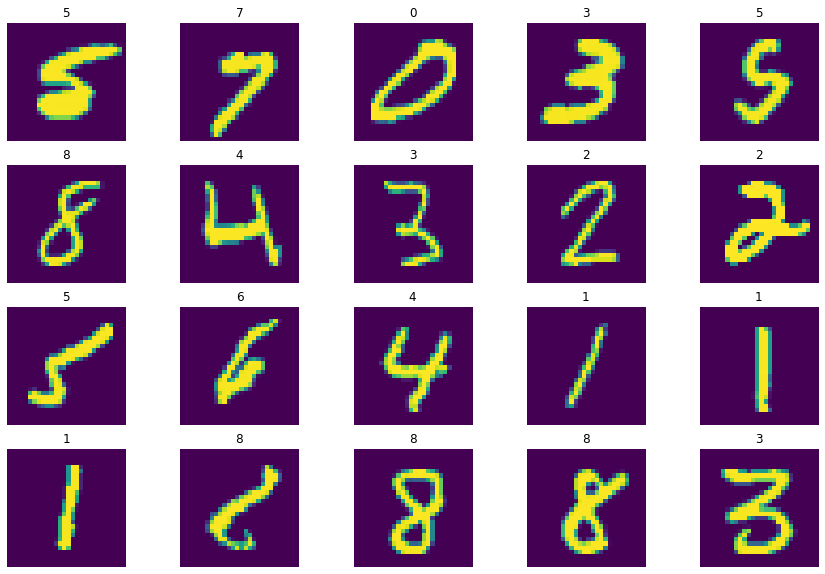

In [15]:
data_example, target_example = next(iter(train_dataloader))  # Loading batchsize

plt.figure(figsize=(15, 10))
for i in range(1, 21):
    plt.subplot(4, 5, i)
    plt.imshow(data_example[i-1].reshape(WIDTH, HEIGHT, CHANNELS))
    plt.title(target_example[i - 1].item())
    plt.axis(False)
    

# MODEL LENET5

In [16]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5,
                               padding='same',
                               stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.conv3 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5,
                               stride=1)
        self.pool4 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)
        self.conv5 = nn.Conv2d(in_channels=16,
                               out_channels=120,
                               kernel_size=5,
                               stride=1)
        self.fc6 = nn.Linear(in_features=120*1*1,
                             out_features=84)
        self.softmax7 = nn.Linear(in_features=84,
                                  out_features=10)
    
    def forward(self, x):
        # x = 28, 28, 1
        x = F.tanh(self.conv1(x))
        # x = 28, 28, 6
        x = self.pool2(x)
        # x = 14, 14, 6
        x = F.tanh(self.conv3(x))
        # x = 10, 10, 16
        x = self.pool4(x)
        # x = 5, 5, 16
        x = F.tanh(self.conv5(x))
        # x = 1, 1, 120
        x = x.view(-1, 120 * 1 * 1)
        # x = -120
        x = F.tanh(self.fc6(x))
        # x = 84
        x = self.softmax7(x)
        # x = 10
        return x

In [17]:
model = LeNet5().to(device)

# CRITERION (LOSS) & OPTIMIZER

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=1e-2)

# SCHEDULER LEARNING RATE

In [19]:
scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[10, 15, 20], gamma=0.1)

# TRAINING

In [20]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [21]:
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    
    num_corrects = 0
    num_samples = 0
    
    model.train() 
    for images, targets in train_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        
        out = model(images)
        loss = criterion(out, targets)
        
        # Backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item() * images.size(0)
        
        # Acc Train
        _, predicted = torch.max(out, 1)
        num_corrects += (predicted == targets).sum().item()
        num_samples += images.size(0)
    
    
    running_loss_val = 0.0
    num_corrects_val = 0
    num_samples_val = 0
    
    model.eval()
    for images, targets in val_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        
        # compute loss

        out = model(images)
        loss_val = criterion(out, targets)
        
        running_loss_val += loss_val.item() * images.size(0)
        
        # Acc Val
        _, predicted = torch.max(out, 1)
        num_corrects_val += (predicted == targets).sum().item()
        num_samples_val += images.size(0)
    
    scheduler.step()
    
    epoch_loss = running_loss / dataset_train_size
    epoch_loss_val = running_loss_val / dataset_val_size
    epoch_acc = 100 * num_corrects / num_samples
    epoch_acc_val = 100 * num_corrects_val / num_samples_val
    
        
    print(f"{epoch+1}/{EPOCHS} | loss = {epoch_loss:.4f} | acc = {epoch_acc:.4f} | Val loss = {epoch_loss_val:.4f} | Val acc = {epoch_acc_val:.4f} | lr = {get_lr(optimizer)}")

/home/brenoav/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


1/30 | loss = 1.3723 | acc = 60.9655 | Val loss = 0.5125 | Val acc = 85.7600 | lr = 0.01
2/30 | loss = 0.3815 | acc = 89.1400 | Val loss = 0.3316 | Val acc = 90.5200 | lr = 0.01
3/30 | loss = 0.2729 | acc = 91.9218 | Val loss = 0.2583 | Val acc = 92.6600 | lr = 0.01
4/30 | loss = 0.2129 | acc = 93.6927 | Val loss = 0.2057 | Val acc = 94.0800 | lr = 0.01
5/30 | loss = 0.1713 | acc = 94.8418 | Val loss = 0.1721 | Val acc = 95.0000 | lr = 0.01
6/30 | loss = 0.1430 | acc = 95.7055 | Val loss = 0.1450 | Val acc = 95.9200 | lr = 0.01
7/30 | loss = 0.1228 | acc = 96.2982 | Val loss = 0.1297 | Val acc = 96.4000 | lr = 0.01
8/30 | loss = 0.1073 | acc = 96.8618 | Val loss = 0.1146 | Val acc = 96.5000 | lr = 0.01
9/30 | loss = 0.0957 | acc = 97.1782 | Val loss = 0.1048 | Val acc = 96.8200 | lr = 0.01
10/30 | loss = 0.0861 | acc = 97.4400 | Val loss = 0.0921 | Val acc = 97.2200 | lr = 0.001
11/30 | loss = 0.0781 | acc = 97.6545 | Val loss = 0.0904 | Val acc = 97.2200 | lr = 0.001
12/30 | loss = 0.

# EVALUATING

In [22]:
with torch.no_grad():
    n_corrects = 0
    n_samples = 0
    
    model.eval()
    for images, targets in test_dataloader:
        images = images.to(device)
        targets = targets.to(device)
        out = model(images)
        
        _, predicted = torch.max(out, 1)
        n_samples += images.size(0)
        n_corrects += (targets == predicted).sum().item()
        
    acc = 100 * n_corrects / n_samples
    print(f"Accuracy of the model is {acc:.4f} %")
        

Accuracy of the model is 97.7800 %
